## Wykrywanie zdarzeń za pomocą metody `Abnormal Return, AbR`

Źródło: Event Detection in Financial Markets, *Mohammad Shirdel, Michele Segata, Giuseppe Di Fatta, Antonio Liotta*, Year: 2022 | Conference Paper | Publisher: IEEE

---

Aby wyznaczyć daty zdarzeń (ang. Event Date Detection, EDD) w tym artykule, można zastosować metodę analizy abnormal returns — czyli "nienormalnych zwrotów" ceny akcji — która pozwala identyfikować daty potencjalnych wydarzeń mających wpływ na rynek. Kroki są następujące:

1. Obliczenie rozkładu procentowego zwrotu ceny dla danej daty:

Obliczamy, na ile zwrot ceny w danym dniu jest nietypowy w porównaniu z wcześniejszymi wartościami. Aby to zrobić, stosujemy procentowe zwroty:
$$
pctl = (R_0, ..., R_n) = \frac{\sum_{i=1}^n step(sign(R_0)*(R_0 - R_i))}{n}
$$
Gdzie:
- $R_0$ to zwrot ceny w dniu, dla którego liczymy wartość, a $R_1, ..., R_n$ zwroty w n wcześniejszych dniach,
- Funkcja `step(x)` wynosi $1$, gdy $x>0$ , i $0$ w przeciwnym przypadku.

2. Wyznaczenie miary anormalności
Aby ułatwić identyfikację daty zdarzenia, warto wprowadzić miarę nienormalności zwrotu (*Abnormal Return, AbR*), która bierze pod uwagę zarówno zmienność długookresową, jak i krótkookresową. Formuła nienormalności jest następująca:
$$
    AbR(R_0​,R_1​,…,R_L​)=pctl(R_0​,R_1​,…,R_L​)×pctl(∣R_0​∣,∣R_1​∣,…,∣R_L​∣)×pctl(R_0​,R_1​,…,R_S​)×pctl(∣R_0​∣,∣R_1​∣,…,∣R_S​∣)
$$
Gdzie:
- $L$ to liczba dni dla długiego okresu,
- $S$ to liczba dni dla krótkiego okresu.

3. Wyznaczenie daty zdarzenia

Po obliczeniu wartości AbR dla danego dnia, porównuje się ją z ustalonym progiem, np. $0,94$ (zgodnie z artykułem). Jeśli *AbR* przekroczy próg, dzień uznaje się za datę zdarzenia.


In [90]:
import numpy as np
import pandas as pd
from scripts import StockPriceDatabase
pd.options.mode.chained_assignment = None 

In [102]:
# Download example market price
spd = StockPriceDatabase()
market_historical = spd.get_stock_price("CCC")

# Get selected data
market_data = market_historical[["Close"]]
market_data["Returns"] = market_data["Close"].pct_change()
market_data.dropna()

,Close,Returns
Date,,
2004-12-03,7.8682,-0.015971
2004-12-06,7.7151,-0.019458
2004-12-07,7.5535,-0.020946
2004-12-08,7.5111,-0.005613
2004-12-09,7.5535,0.005645
...,...,...
2024-09-23,155.6000,0.012362
2024-09-24,152.1000,-0.022494
2024-09-25,178.0000,0.170283


In [104]:
def pctl(returns, n = 5):
    return np.array([np.sum( (np.sign(returns[i]) * (returns[i] - returns[np.max([i-n, 0]): i]) > 0) ) / n 
            for i, _ in enumerate(returns)])

def abr(returns, ns = 5, nl = 30):
    return pctl(returns, nl) * pctl(np.abs(returns), nl) *  pctl(returns, ns) * pctl(np.abs(returns), ns)
    

In [111]:
market_data[market_data["AbR"] > 0.94]

,Close,Returns,AbR
Date,,,
2005-01-21,7.1452,-0.043301,1.000000
2005-02-22,7.8682,0.031192,0.966667
2005-02-23,8.3532,0.061641,1.000000
2005-03-23,10.0820,0.067760,1.000000
2005-06-23,11.4500,0.029121,0.966667
...,...,...,...
2024-04-15,83.0000,0.164912,1.000000
2024-05-10,126.0000,0.238938,1.000000
2024-06-25,123.0000,-0.090237,1.000000


### Model sieci LSTM

In [112]:
import numpy as np
import pandas as pd
from scripts import StockPriceDatabase
pd.options.mode.chained_assignment = None 

In [200]:
# Download example market price
spd = StockPriceDatabase()
market_historical = spd.get_stock_price("CCC")

# Get stock prices
prices = market_data["Close"].to_numpy().reshape(-1,1)

In [201]:
def windowing_signal(signal, n=60):
    x = []
    y = []
    for i in range(n, len(signal)):
        x.append(signal[i-n : i, 0])
        y.append(signal[i, 0])
    x = np.array(x)
    y = np.array(y)

    return x.reshape(x.shape[0], x.shape[1], 1), y.reshape(y.shape[0], 1)


In [202]:
## Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Split the data into training and testing sets
train_size = int(len(prices_scaled) * 0.7)
train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]

In [203]:
x_train, y_train = windowing_signal(train_data)
x_test, y_test = windowing_signal(train_data)

In [204]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [205]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: nan
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: nan
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: nan
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: nan
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: nan
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: nan
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: nan
Epoch 8/100
 49/107 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: nan

In [195]:
# Evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
test_loss = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')

Train Loss: 0.000137
Test Loss: 0.000137


In [196]:
y_predict = model.predict(x_test)

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [198]:
(y_test - y_predict).mean()

np.float64(-0.0023854721931414135)

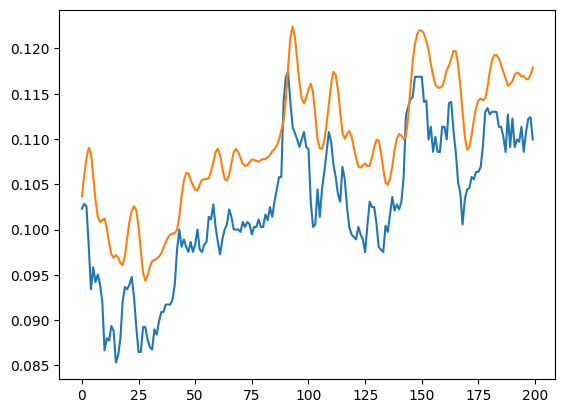

In [183]:
import matplotlib.pyplot as plt

plt.plot(y_test[300:500])
plt.plot(y_predict[300:500])